# **8-4. Batch Nomalization**
기울기가 소멸되는 Gradient Vanishing, 기울기가 너무 커버리게 되는 Gradient Exploding을 예방할 수 있는 또 하나의 방법!   
직접적으로 문제를 해결할 수 있어서, 학습 과정 전체가 안정적이 된다!   

### **Internal Covariate Shift**
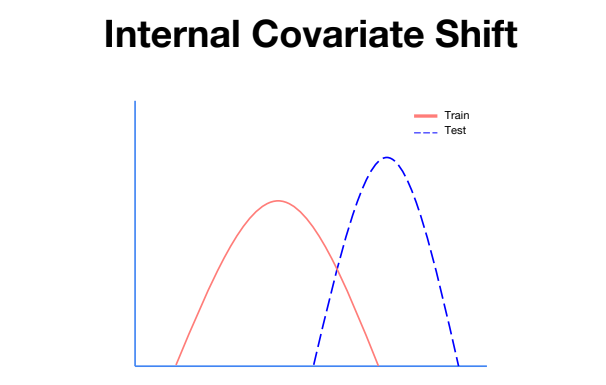

Covaraite Shift: Train set과 Test set의 분포에 차이가 있다.  
얘가 gradient vanishing, exploding 만든다! 라고 batch normalization 저자께서 말씀하셨습니다.   


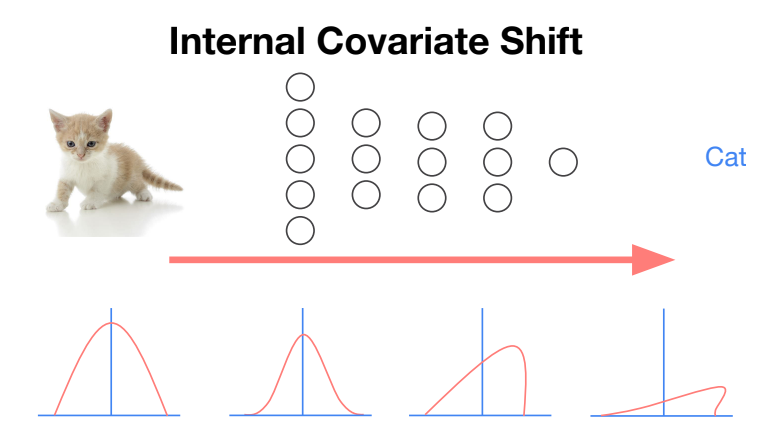

input을 정규화 해도 Covariate Shift가 발생을 한다!   
각 층을 지날 때 마다 분포의 변화로 인해 Convariate Shift가 발생하고, 층이 깊을수록 더 심하게 문제가 발생한다. 때문에, 분포가 유지되도록 batch nomalization을 해야 한다! 고 말씀하셨습니다.

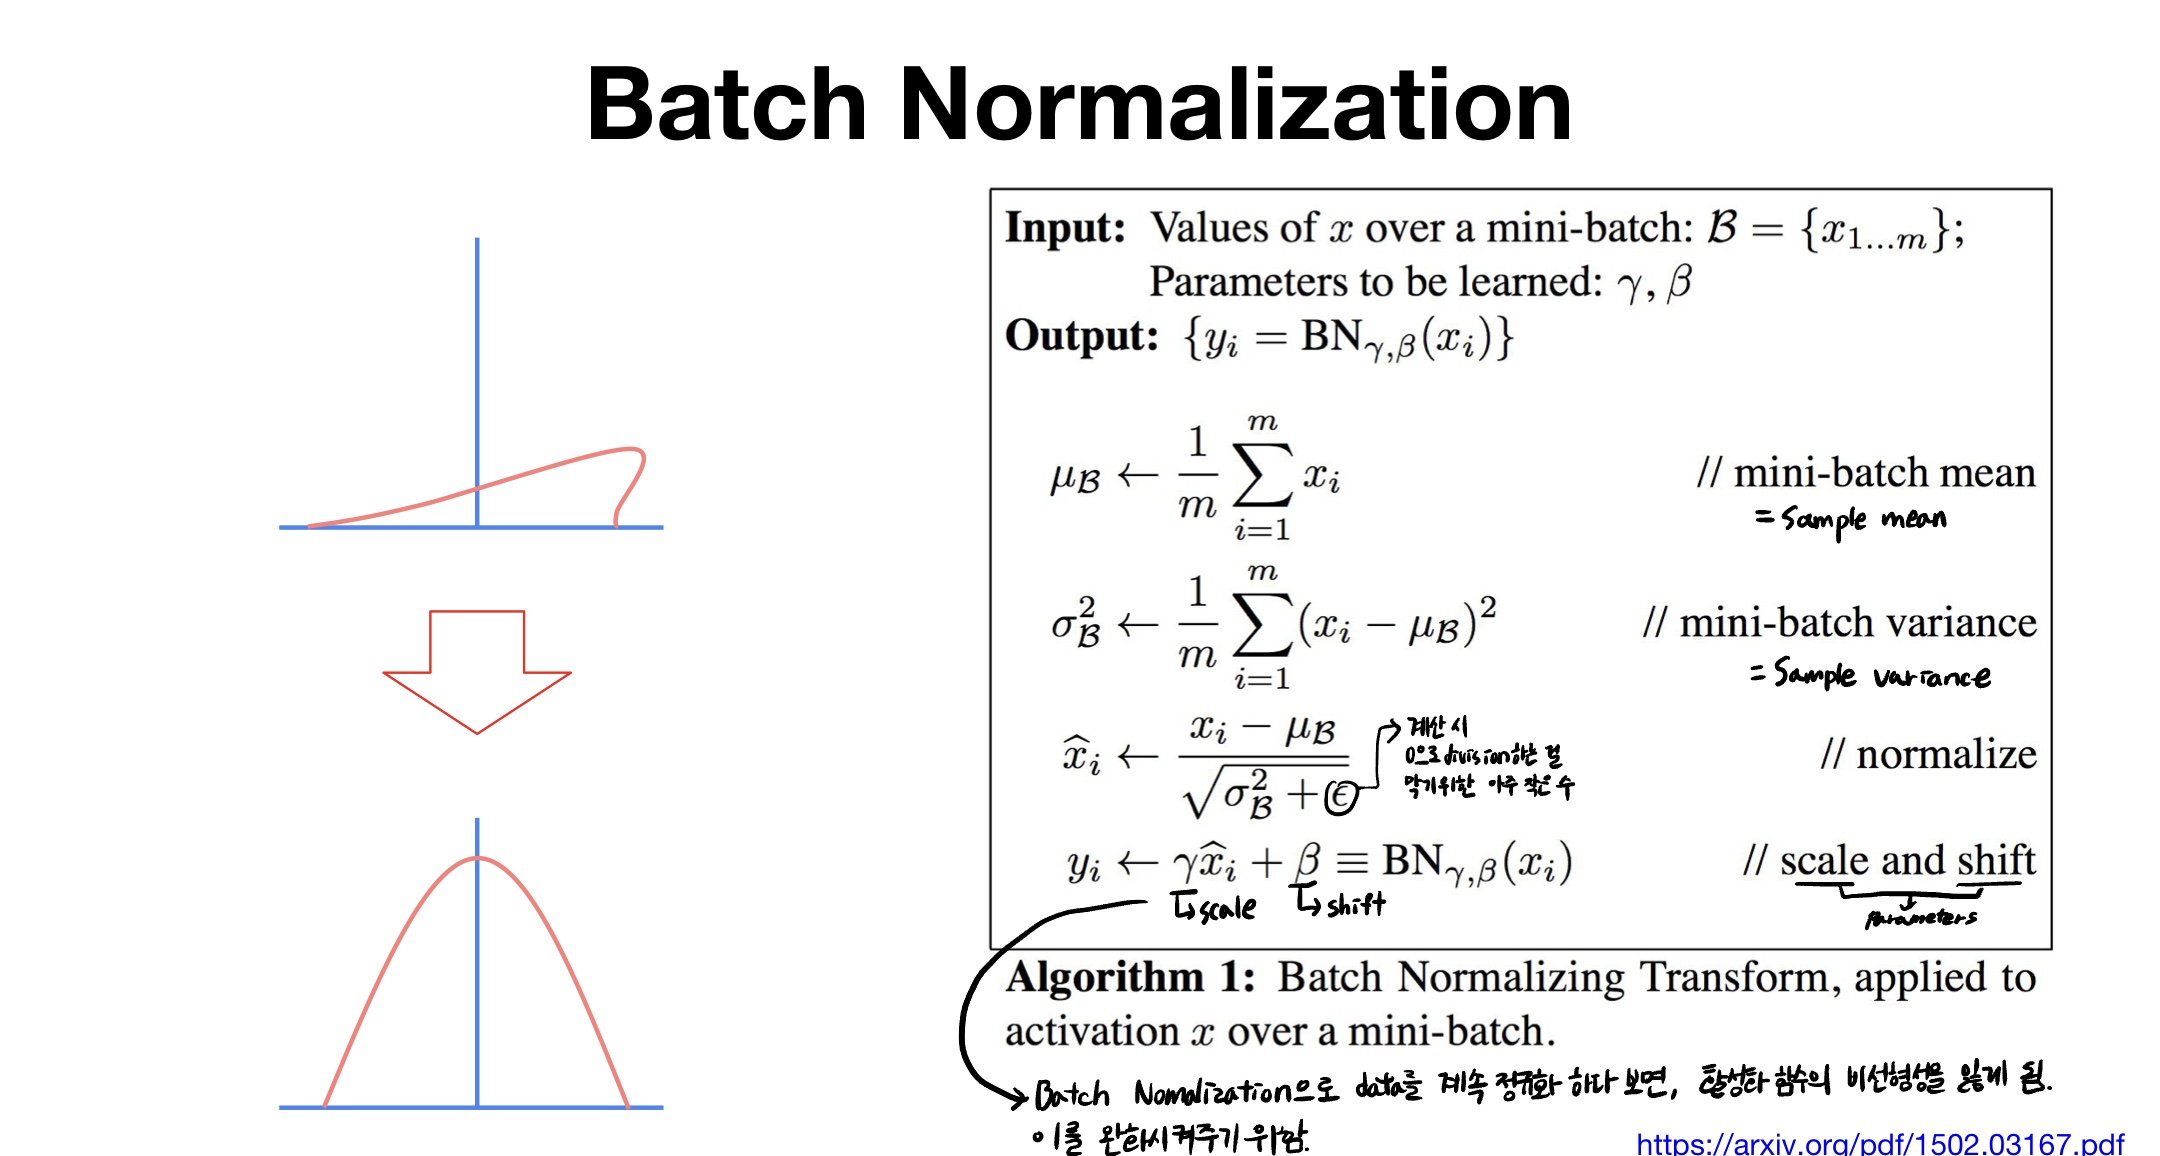

- training  →  μ,σ 계산(sample)  →  정규화  →  𝛶x̂ + β   
    - x̂: 정규화된 x   
<br>

학습 시 입력 batch로부터 구한 평균과 분산 = sample mean, sample variance     
<br>

**[문제점]**   
x가 달라지면 μ,σ도 달라져요    
예를 들어, batch A가 있다고 했을 때, 다른 data는 다 같은데 맨 아래 2줄의 data만 바뀐다면?   
위에 부분의 sample이 이전과 동일하더라도, 전혀 다른 μ,σ값을 가지게 된다.   
<br>
이를 방지하기 위해, Sample mean, sample variance를 batch별로 따로 저장해 놨다가, 각각 평균을 구해서 learning mean, learning variance를 구한다. 이 값들은 실제 nomalize 단계에서 사용된다.    
Learning mean, learning variance는 입력 batch에 상관 없이 고정된 값이 된다.     
<br>
training set로 학습 시 계산된 μ,σ값을 따로 저장해 놓았다가, test시 따로 저장된 learning μ,σ값을 가져다 쓰게 된다.    
(train 모드, eval 모드를 나눠서 진행해야 한다!)    
Batch의 구성이 달라져도, 같은 sample에는 같은 output을 가지게 된다.
<br>

- test → 저장된 learning μ,σ를 가져다 쓴다 →  𝛶x̂ + β

In [ ]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pylab as plt

In [ ]:
device = 'cuda' if torch.cuda.is_available() else  'cpu'

torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)

In [ ]:
#parameters
learning_rate = 0.01
training_epochs = 10
batch_size = 32

In [ ]:
#mnist dataset
mnist_train = dsets.MNIST(root='./',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

mnist_test = dsets.MNIST(root='./',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 108310133.55it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 76426305.25it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27435521.53it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7868867.73it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(dataset = mnist_train,
                                      batch_size = batch_size,
                                      shuffle = True,
                                      drop_last = True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [ ]:
#nn layers
linear1 = torch.nn.Linear(784, 32, bias = True)
linear2 = torch.nn.Linear(32, 32, bias = True)
linear3 = torch.nn.Linear(32, 10, bias = True)
relu = torch.nn.ReLU()
bn1 = torch.nn.BatchNorm1d(32) #1차원 입력에 대해서 정규화 수행
bn2 = torch.nn.BatchNorm1d(32) #일반적으로 활성화 함수 이전에 사용한다.

nn_linear1 = torch.nn.Linear(784, 32, bias=True)
nn_linear2 = torch.nn.Linear(32, 32, bias=True)
nn_linear3 = torch.nn.Linear(32, 10, bias=True)

In [ ]:
#model
bn_model = torch.nn.Sequential(linear1, bn1, relu,
                            linear2, bn2, relu,
                            linear3).to(device)
nn_model = torch.nn.Sequential(nn_linear1, relu,
                               nn_linear2, relu,
                               nn_linear3).to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [ ]:
# Save Losses and Accuracies every epoch
# We are going to plot them later

train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(1, training_epochs+1):
    bn_model.train() #모델을 train mode로 설정

    for X, Y in train_loader:
        X = X.view(-1, 784).to(device)
        Y = Y.to(device)

        bn_prediction = bn_model(X)
        bn_optimizer.zero_grad()
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()


    with torch.no_grad():
        bn_model.eval() #모델을 evaluation mode로 설정

        # train set로 model test
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 784).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y #argmax: 가장 높은 갚을 가진 인덱스 반환
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch,  bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))


        #test set로 model test
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')



[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.10130(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.16851(nn_acc:0.95)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.11749(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.19457(nn_acc:0.95)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07985(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.14347(nn_acc:0.96)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.10551(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.17799(nn_acc:0.95)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.07796(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.15820(nn_acc:0.96)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.10891(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.19293(nn_acc:0.95)

[Epoch 5-TRAIN] Batchnorm Loss(Acc): bn_loss:0.06888(bn_acc:0.98) vs No Batchnorm Loss(Acc): nn_loss:0.14058(nn_acc:0.96)
[Epoch 5-VALID] Batchnorm Loss(Acc): bn_loss:0.10126(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.20342(nn_acc:0.95)

[Epoch 6-TRAIN] Batc

In [ ]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None: #->: 함수의 리턴값에 대한 주석
                                                                  #:은 매개변수(parameter)의 형태에 대한 주석
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label = 'With BN')
    plt.plot(nn, label = 'Without BN')
    if ylim: #y축의 범위 설정
        plt.ylim(ylim)

    if title:
        plt.title(title)

    plt.legend() #그래프에 범례 추가하기
    plt.grid('on')
    plt.show()


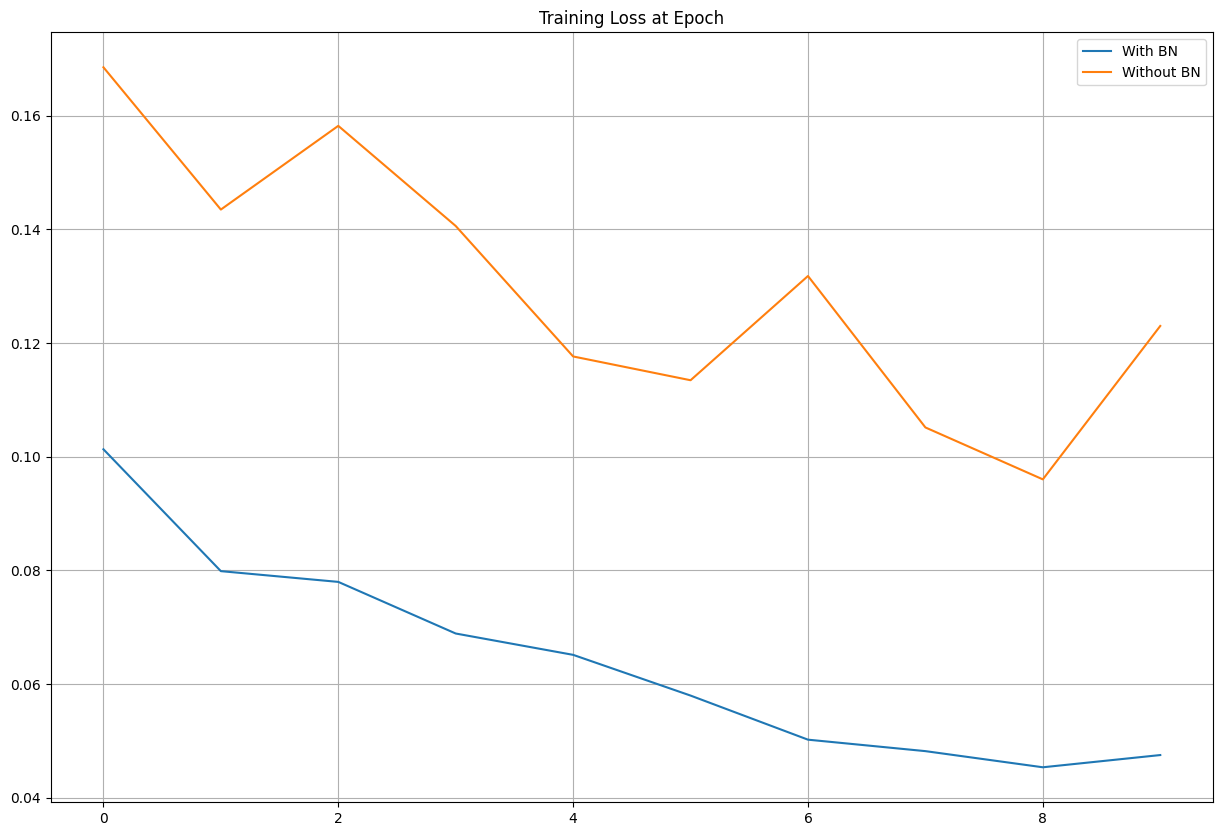

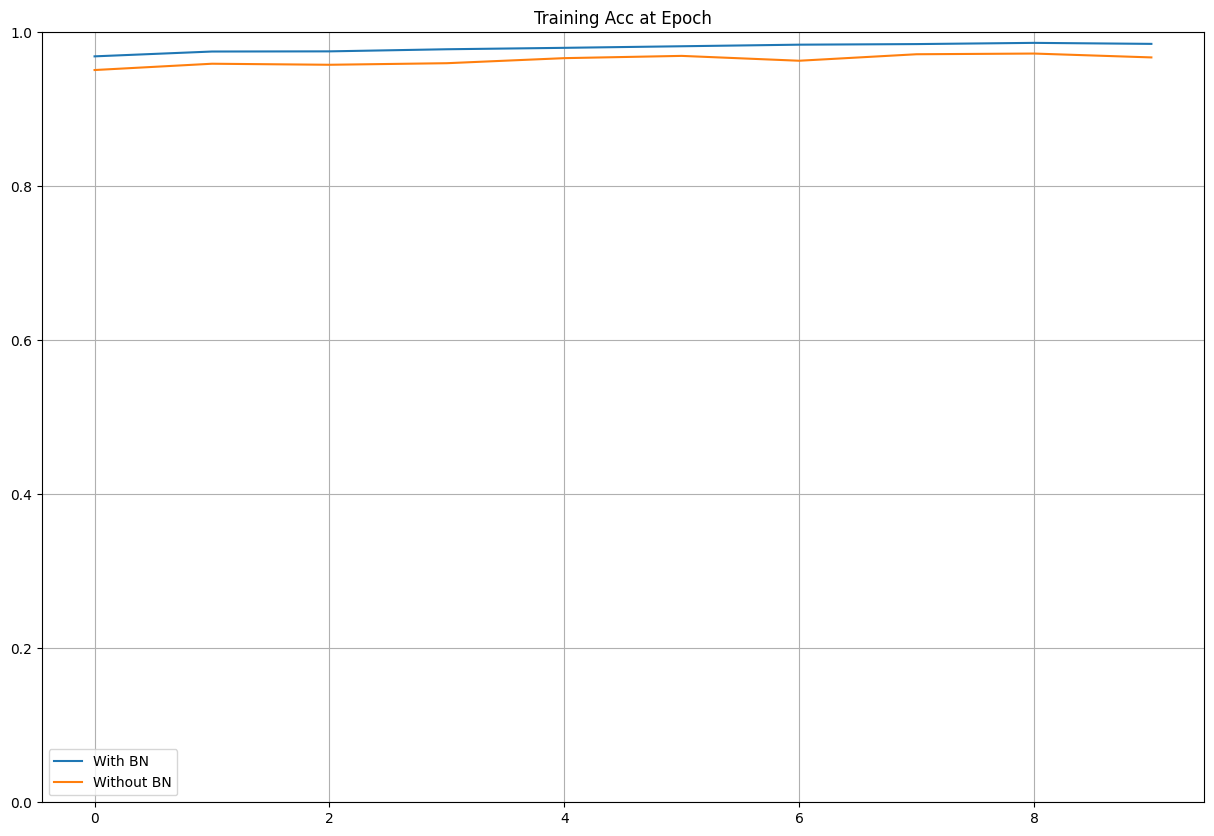

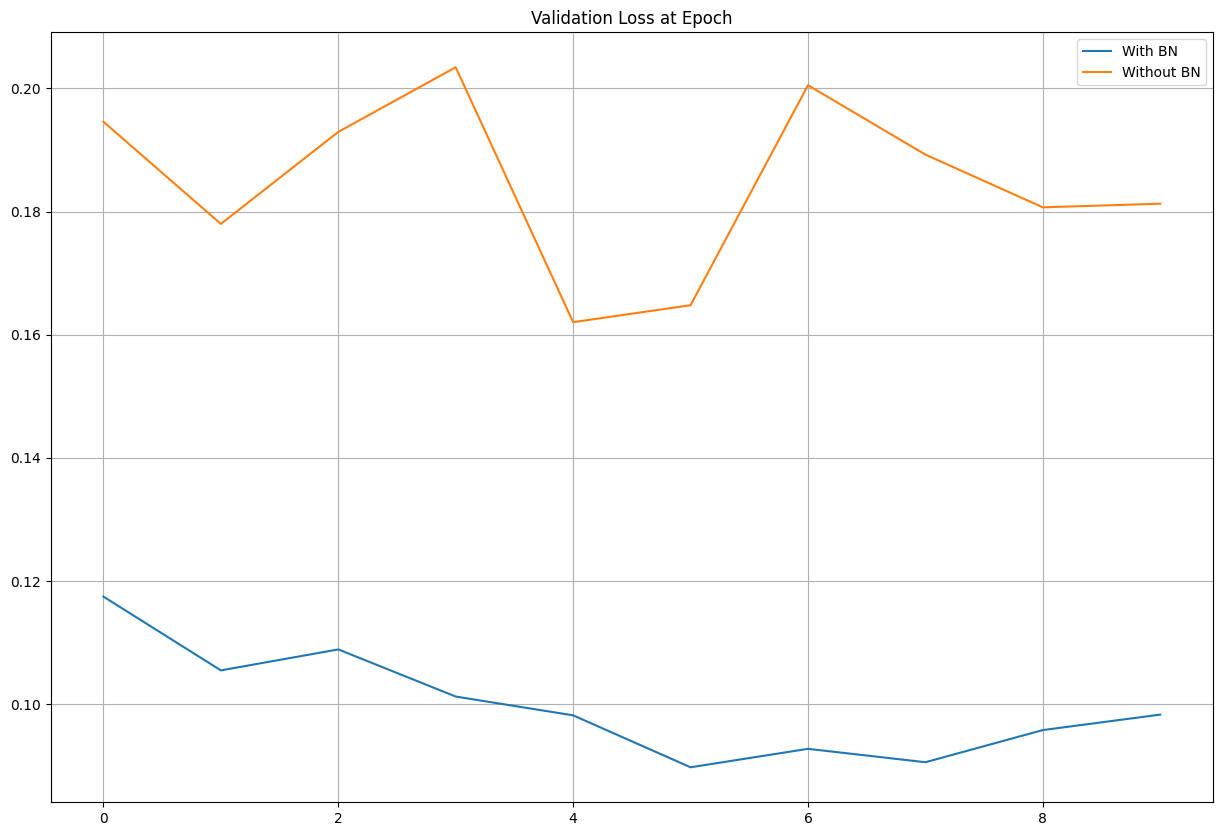

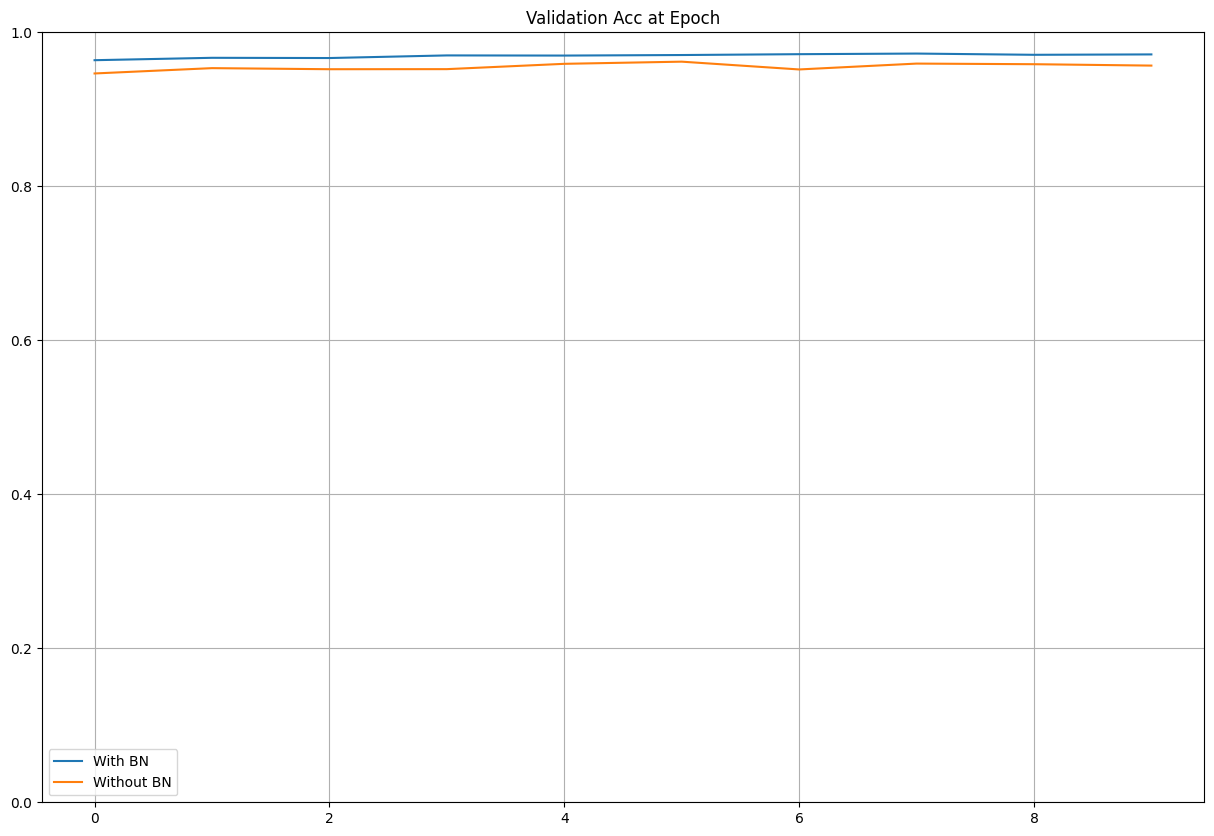

In [ ]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')